In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import string
import copy
import itertools

from models import ContinuousIncrementalRSA
from utils import *
import time
from tqdm import tqdm

## Fig. 1a: Manipulating inherent informativeness and contextual informativeness

In [2]:
semantic_value_range = np.linspace(0.5, 1, num=11)
adjectives = [c for c in string.ascii_lowercase[:13]]
nouns = [c for c in string.ascii_lowercase[13:]]

In [3]:
all_probs = []
for num_adj in range(2, 6):
    for num_noun in [3]:
        print('num adjectives', num_adj, 'num nouns', num_noun)
        
        adj_subset = adjectives[:num_adj]
        noun_subset = nouns[:num_noun]
        
        objects = get_all_objects(adj_subset, noun_subset)
        utterances = get_all_utterances(adj_subset, noun_subset)
        
        probs = np.zeros(shape=(len(semantic_value_range), len(semantic_value_range)))
        for i in range(len(semantic_value_range)):
            for j in range(len(semantic_value_range)):
                v_adj = semantic_value_range[i]
                v_noun = semantic_value_range[j]

                rsa = ContinuousIncrementalRSA(adj_subset, noun_subset, objects, utterances, v_adj=v_adj, v_noun=v_noun)
                p_adj_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'a n')
                p_noun_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'n a')

                normalized_p_adj_first = p_adj_first / (p_adj_first + p_noun_first)
                normalized_p_noun_first = p_noun_first / (p_adj_first + p_noun_first)
                probs[i, j] = normalized_p_noun_first

        all_probs.append(probs)

num adjectives 2 num nouns 3
num adjectives 3 num nouns 3
num adjectives 4 num nouns 3
num adjectives 5 num nouns 3


In [4]:
np.arange(0.5, 1.05, 0.05)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [17]:
all_probs[i]

array([[0.44444444, 0.46273382, 0.52084031, 0.61078969, 0.71087407,
        0.80001238, 0.86830705, 0.91589312, 0.94724767, 0.96727081,
        0.97984121],
       [0.42690427, 0.44505081, 0.50302879, 0.59373171, 0.69603458,
        0.78839577, 0.85996862, 0.91025935, 0.94358643, 0.96494875,
        0.97839157],
       [0.36785951, 0.38517178, 0.44155623, 0.53307091, 0.64143038,
        0.74429198, 0.82752105, 0.88794764, 0.92891409, 0.9555711 ,
        0.9725081 ],
       [0.27608128, 0.29104715, 0.34129513, 0.42795362, 0.53964115,
        0.65604467, 0.75868353, 0.83851998, 0.89542849, 0.93374649,
        0.95864305],
       [0.18112405, 0.19229834, 0.23104839, 0.30257067, 0.40468401,
        0.52518581, 0.645789  , 0.75070079, 0.83237016, 0.89098055,
        0.93075534],
       [0.10723724, 0.11448452, 0.14027482, 0.19066455, 0.26961116,
        0.37524442, 0.4974913 , 0.62051475, 0.72946188, 0.81610321,
        0.87950121],
       [0.05937994, 0.06362078, 0.07897369, 0.11016465, 0.

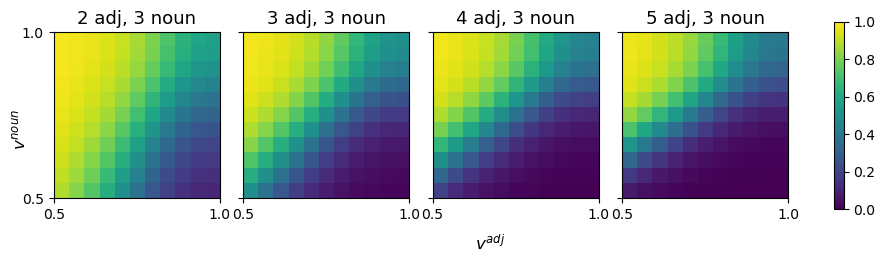

In [27]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 2.5))
#for i in range(2):
    #for j in range(2):
for i, ax in enumerate(axs):
        #ax = axs[i, j]
    im = ax.imshow(np.flip(all_probs[i]), origin='lower', vmin=0, vmax=1, extent=[0.5, 1, 0.5, 1])
    ax.set_title(str(i+2)+" adj, 3 noun", fontsize=13)
    #ax.tick_params(labelsize=14)
    ax.set_xticks([0.5, 1])
    ax.set_yticks([0.5, 1])
    fig.supxlabel('$v^{adj}$')
    fig.supylabel('$v^{noun}$')

#fig.suptitle('P(NOUN-ADJ)', size=16)

#fig.text(0.5, 0.15, "$v_{noun}$", ha="center", va="center", fontsize=14)
#fig.text(0.08, 0.5, "$v_{adj}$", ha="center", va="center", rotation=90, fontsize=14)
fig.tight_layout(pad=0.5)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
   
#plt.colorbar(im, cax=cax)
cbar = plt.colorbar(im, ax=axs)
#cbar.ax.tick_params(labelsize=14)
#plt.savefig('semantic_values.png')

## Fig. 1b: Manipulate contextual informativeness and lexical informativeness

Assume fixed semantic values $v_{\text{adj}} = 0.95, v_{\text{noun}} = 0.99$

In [6]:
start_num = 2
num_word_range = range(start_num, 10)
objects = [
    {'color': 'a', 'shape': 'n', 'string': 'a n'},
    {'color': 'a', 'shape': 'm', 'string': 'a m'},
    {'color': 'b', 'shape': 'n', 'string': 'b n'}#,
    #{'color': 'c', 'shape': 'o', 'string': 'c o'}
]
adjectives = [c for c in string.ascii_lowercase[:13]]
nouns = [c for c in string.ascii_lowercase[13:]]

In [7]:
diff = max(num_word_range) - min(num_word_range) + 1

        
probs = np.zeros(shape=(diff, diff))
for num_adj in num_word_range:
    for num_noun in num_word_range:
        adj_subset = adjectives[:num_adj]
        noun_subset = nouns[:num_noun]

        possible_utterances = get_all_utterances(adj_subset, noun_subset)

        rsa = ContinuousIncrementalRSA(adj_subset, noun_subset, objects, possible_utterances)
        p_adj_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'a n')
        p_noun_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'n a')

        normalized_p_adj_first = p_adj_first / (p_adj_first + p_noun_first)
        normalized_p_noun_first = p_noun_first / (p_adj_first + p_noun_first)
        probs[num_adj-start_num, num_noun-start_num] = normalized_p_noun_first

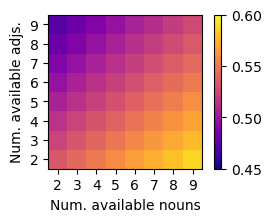

In [8]:
fig, ax = plt.subplots(figsize=(3, 2))
im = ax.imshow(probs, origin='lower', cmap='plasma', vmin=0.45, vmax=0.6, extent=[1.5, 9.5, 1.5, 9.5])
ax.set_xticks(list(range(2, 10)))
ax.set_yticks(list(range(2, 10)))
#ax.set_title('P(NOUN-ADJ)', size=16)
ax.set_xlabel('Num. available nouns')
ax.set_ylabel('Num. available adjs.')
cbar = plt.colorbar(im)

## Fig. 1c: Vary the informativeness of the adjective by manipulating the number of duplicates

In [9]:
adjectives = ["red", "blue", "green"]
nouns = ["pin", "dress", "truck"]
objects = get_all_objects(adjectives, nouns)
"""
objects = [
    {'color': 'red', 'shape': 'pin', 'string': 'red pin'},
    {'color': 'red', 'shape': 'dress', 'string': 'red dress'},
    {'color': 'blue', 'shape': 'pin', 'string': 'blue pin'},
    {'color': 'green', 'shape': 'truck', 'string': 'green truck'}
]
"""
utterances = get_all_utterances(adjectives, nouns)
objects

[{'color': 'red', 'shape': 'pin', 'string': 'red pin'},
 {'color': 'red', 'shape': 'dress', 'string': 'red dress'},
 {'color': 'red', 'shape': 'truck', 'string': 'red truck'},
 {'color': 'blue', 'shape': 'pin', 'string': 'blue pin'},
 {'color': 'blue', 'shape': 'dress', 'string': 'blue dress'},
 {'color': 'blue', 'shape': 'truck', 'string': 'blue truck'},
 {'color': 'green', 'shape': 'pin', 'string': 'green pin'},
 {'color': 'green', 'shape': 'dress', 'string': 'green dress'},
 {'color': 'green', 'shape': 'truck', 'string': 'green truck'}]

In [10]:
objs_to_visualize = [{'color': 'red', 'shape': 'pin', 'string': 'red pin'},
                     {'color': 'blue', 'shape': 'pin', 'string': 'blue pin'},
                     {'color': 'red', 'shape': 'dress', 'string': 'red dress'},
                     {'color': 'green', 'shape': 'truck', 'string': 'green truck'}
                    ]
obj_names = [obj['string'] for obj in objs_to_visualize]
max_num_duplicates = 5
num_utt_types = 2
probs_map = {obj: np.zeros(shape=(max_num_duplicates, num_utt_types)) for obj in obj_names}
probs_map

{'red pin': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'blue pin': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'red dress': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'green truck': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [11]:
for dup_idx in range(max_num_duplicates):
    objects_copy = copy.deepcopy(objects)
    for _ in range(dup_idx):
        objects_copy.append({'color': 'red', 'shape': 'pin', 'string': 'red pin'})
    print('Num duplicates', dup_idx)
    rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                    nouns=nouns,
                                    objects=objects_copy,
                                    utterances=utterances,
                                )
    
    for obj_idx, obj in enumerate(objs_to_visualize):
        tokens = [obj['color'], obj['shape']]
        options = list(itertools.permutations(tokens))

        for utt_idx, option in enumerate(options):
            utt = " ".join(option)
            #print(utt)
            p = rsa.incremental_pragmatic_speaker(obj, utt)
            #print(p)
            probs_map[obj['string']][dup_idx][utt_idx] = p

Num duplicates 0
Num duplicates 1
Num duplicates 2
Num duplicates 3
Num duplicates 4


In [12]:
probs_map

{'red pin': array([[0.39942481, 0.59471514],
        [0.41240869, 0.55367467],
        [0.40991211, 0.51465945],
        [0.40081888, 0.48070086],
        [0.38976219, 0.4524374 ]]),
 'blue pin': array([[0.39942481, 0.59471514],
        [0.71412979, 0.28150973],
        [0.87089441, 0.12369969],
        [0.9351796 , 0.05829723],
        [0.96223134, 0.03018168]]),
 'red dress': array([[0.39942481, 0.59471514],
        [0.15410686, 0.83982679],
        [0.06140848, 0.93186607],
        [0.02734383, 0.96551906],
        [0.01352584, 0.97904269]]),
 'green truck': array([[0.39942481, 0.59471514],
        [0.3847621 , 0.60953088],
        [0.37055803, 0.62387035],
        [0.35681684, 0.63773189],
        [0.34353976, 0.65111648]])}

In [13]:
normalized_probs_map = {}
for key, val in probs_map.items():
    normalized_val = np.sum(val, axis=1)
    normalized_val = normalized_val[:, np.newaxis]
    normalized_probs = val / normalized_val
    normalized_probs_map[key] = normalized_probs

/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/339071464.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)
/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/339071464.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)
/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/339071464.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)
/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/339071464.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)


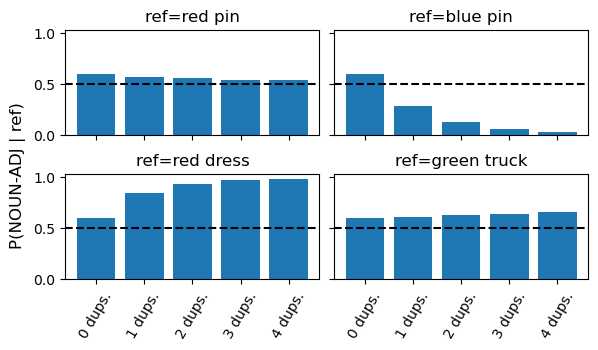

In [14]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 3.5))
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        flat_idx = np.ravel_multi_index((i, j), (2, 2))
        obj_name = obj_names[flat_idx]
        vals_for_hist = normalized_probs_map[obj_name][:, -1]
        x_labels = [str(i) + ' dups.' for i in range(5)]
        ax.bar(x_labels, vals_for_hist)
        ax.axhline(y=0.5, ls='--', c='black', zorder=1)
        ax.set_xticklabels(x_labels, rotation=60)
        #ax.set_ylabel("obj=" + obj_name)
        ax.set_title('ref=' + obj_name)
        fig.supylabel('P(NOUN-ADJ | ref)')
#fig.suptitle('P(NOUN-ADJ | obj)', fontsize=16)#, x=0.5, y=0.93)
#plt.savefig('duplicates.png')
fig.tight_layout(pad=0.7)

/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/428675637.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)
/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/428675637.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)
/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_62838/428675637.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=60)


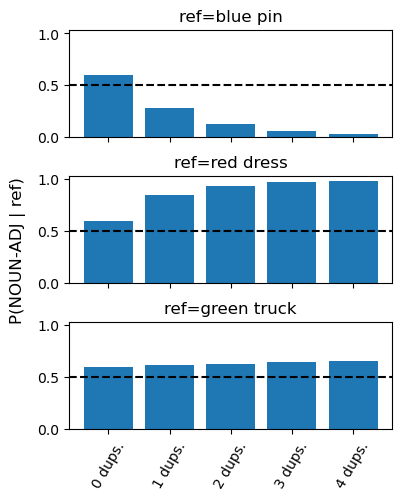

In [15]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(4, 5))
for i in range(3):
    ax = axs[i]
    #flat_idx = np.ravel_multi_index((i, j), (2, 2))
    obj_name = obj_names[i+1]
    vals_for_hist = normalized_probs_map[obj_name][:, -1]
    x_labels = [str(num_dups) + ' dups.' for num_dups in range(5)]
    ax.bar(x_labels, vals_for_hist)
    ax.axhline(y=0.5, ls='--', c='black', zorder=1)
    ax.set_xticklabels(x_labels, rotation=60)
    #ax.set_ylabel("obj=" + obj_name)
    ax.set_title('ref=' + obj_name)
    fig.supylabel('P(NOUN-ADJ | ref)')
#fig.suptitle('P(NOUN-ADJ | obj)', fontsize=16)#, x=0.5, y=0.93)
#plt.savefig('duplicates.png')
fig.tight_layout(pad=0.7)